<a href="https://colab.research.google.com/github/MarinaNasser/-Statistics/blob/main/Burn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.4 MB/s eta 0:00:00


In [2]:
import os
import torch
import optuna
import random
import re
import shutil
from google.colab import drive
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from numpy.random import MT19937
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR
from numpy.random import RandomState, SeedSequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

In [3]:
# Choose your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data loading phase

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [6]:
# Open Gp drive/Burn dataset/classification , click on classification-->organize-->add shortcut--my drive
folder_path = '/content/drive/My Drive/classification'

# List files in the folder
files = os.listdir(folder_path)
print(files)

['From roboflow', 'From kaggle', 'older labels kaggle', 'BIP_US', 'BIPimages_labels', 'Mixed_dataset_BIPUS_cieLAB', 'dr_labelled_imgs', 'dr_labelled_imgs_cielab', 'Mixed_dataset_CIELAB', 'dr_labelled_imgs_202402027']


## Paths

In [7]:
final_labels = []

roboflow_train_images_path = '/content/drive/My Drive/classification/From roboflow/train'
roboflow_train_labels_path = '/content/drive/My Drive/classification/From roboflow/train/_classes.csv'
roboflow_valid_images_path = '/content/drive/My Drive/classification/From roboflow/valid'
roboflow_valid_labels_path = '/content/drive/My Drive/classification/From roboflow/valid/_classes.csv'

kaggle_images_path = '/content/drive/My Drive/classification/From kaggle'
older_labels_path = '/content/drive/My Drive/classification/older labels kaggle'

BIP_US_path = '/content/drive/My Drive/classification/BIPimages_labels'
dr_labelled_imgs_path = '/content/drive/My Drive/classification/dr_labelled_imgs'

Mixed_dataset_cieLAB_path ='/content/drive/My Drive/classification/Mixed_dataset_CIELAB'


mixed_dataset_path = '/content/Mixed_dataset'
if not os.path.exists(mixed_dataset_path):
    os.makedirs(mixed_dataset_path)

cielab_mixed_dataset_path = '/content/cielab_Mixed_dataset'
if not os.path.exists(cielab_mixed_dataset_path):
    os.makedirs(cielab_mixed_dataset_path)

## Kaggle Dataset

In [8]:
def get_label_kaggle(older_labels_path, img_name):

    text_filename = f"{img_name}.txt"
    text_file_path = os.path.join(older_labels_path, text_filename)

    if os.path.exists(text_file_path):
      try:
        with open(text_file_path, "r") as file:
            file_contents = file.readlines()
            if not file_contents:
                print(f"No content found in file: {text_file_path}")
                return None

            # Extracting the first column values
            first_column_values = [int(line.split()[0]) for line in file_contents]

            # Calculating the mode of the first column values
            mode = Counter(first_column_values).most_common(1)

            return mode[0][0]

      except FileNotFoundError:
          print(f"File {text_file_path} is not found.")
          return None

      except Exception as e:
          print(f"An error occurred: {e}")
          return None

In [9]:
# Kaggle images
for root, dirs, files in os.walk(kaggle_images_path):
    for file in files:
        img_name = file.split('.')[0]  # Extracts the name without the extension
        if ' - Copy' in img_name:
            img_name = img_name.split(' - Copy')[0]  # Removes the '- Copy' part
        label = get_label_kaggle(older_labels_path,img_name)
        if label is not None:
            final_labels.append(label)
            new_filename = f'{len(final_labels) - 1}_{label}.jpg'
            shutil.copy2(os.path.join(kaggle_images_path, file), os.path.join(mixed_dataset_path, new_filename))

## Roboflow Dataset

In [10]:
def get_label_roboflow(labels_file_path, img_name, roboflow_labels_dict):
    try:
        if img_name in roboflow_labels_dict:
            return roboflow_labels_dict[img_name]
        else:
            print(f"Image {img_name} not found in labels file.")
            return None

    except FileNotFoundError:
        print(f"Labels file {labels_file_path} not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [11]:
# Roboflow train images
roboflow_train_labels_dict = {}
roboflow_train_labels = pd.read_csv(roboflow_train_labels_path)
train_image_filenames = roboflow_train_labels['filename'].tolist()
train_labels = roboflow_train_labels[[' 1st degree', ' 2nd degree', ' 3rd degree']].values.tolist()

for filename, label in zip(train_image_filenames, train_labels):
    label_index = label.index(1)  # Get the index where the value is 1
    final_label = label_index
    roboflow_train_labels_dict[filename] = final_label

for root, dirs, files in os.walk(roboflow_train_images_path):
    for file in files:
        img_name = file.split('.')[0]
        label = roboflow_train_labels_dict.get(img_name)
        if 'Copy' in img_name and label is None:
            original_img_name = img_name.split(' - Copy')[0]
            original_img_label = roboflow_train_labels_dict.get(original_img_name)
            if original_img_label:
                roboflow_train_labels_dict[img_name] = original_img_label

for root, dirs, files in os.walk(roboflow_train_images_path):
    for file in files:
      label = get_label_roboflow(roboflow_train_labels_path, file, roboflow_train_labels_dict)
      if label is not None:
        final_labels.append(label)
        new_filename = f'{len(final_labels) - 1}_{label}.jpg'
        shutil.copy2(os.path.join(roboflow_train_images_path, file), os.path.join(mixed_dataset_path, new_filename))


Image _classes (1).csv not found in labels file.
Image _classes.csv not found in labels file.
Image 9_jpg.rf.95c23678045fe98fc597c474684137a4 - Copy.jpg not found in labels file.
Image 9_jpg.rf.95c23678045fe98fc597c474684137a4 - Copy (2).jpg not found in labels file.


In [12]:
# Roboflow Valid images
roboflow_valid_labels_dict = {}
roboflow_valid_labels = pd.read_csv(roboflow_valid_labels_path)
valid_image_filenames = roboflow_valid_labels['filename'].tolist()
valid_labels = roboflow_valid_labels[[' 1st degree', ' 2nd degree', ' 3rd degree']].values.tolist()

for filename, label in zip(valid_image_filenames, valid_labels):
    label_index = label.index(1)  # Get the index where the value is 1
    final_label = label_index
    roboflow_valid_labels_dict[filename] = final_label

for root, dirs, files in os.walk(roboflow_valid_images_path):
    for file in files:
        img_name = file.split('.')[0]
        label = roboflow_valid_labels_dict.get(img_name)
        if 'Copy' in img_name and label is None:
            original_img_name = img_name.split(' - Copy')[0]
            original_img_label = roboflow_valid_labels_dict.get(original_img_name)
            if original_img_label:
                roboflow_valid_labels_dict[img_name] = original_img_label

for root, dirs, files in os.walk(roboflow_valid_images_path):
    for file in files:
      label = get_label_roboflow(roboflow_valid_labels_path, file, roboflow_valid_labels_dict)
      if label is not None:
        final_labels.append(label)
        new_filename = f'{len(final_labels) - 1}_{label}.jpg'
        shutil.copy2(os.path.join(roboflow_valid_images_path, file), os.path.join(mixed_dataset_path, new_filename))


Image _classes.csv not found in labels file.


## BIP_US Dataset

In [13]:
# # BIP_US images
# for root, dirs, files in os.walk(BIP_US_path):
#     for file in files:
#         img_name = file.split('.')[0]
#         label = file.split('_')[-1].split('.')[0]
#         final_labels.append(label)
#         new_filename = f'{img_name}.jpg'
#         shutil.copy2(os.path.join(BIP_US_path, file), os.path.join(mixed_dataset_path, new_filename))

## Doctor Labeled Images

In [14]:
# # dr labeled images
# for root, dirs, files in os.walk(dr_labelled_imgs_path):
#     for file in files:
#         img_name = file.split('.')[0]  # Extracts the name without the extension
#         label = file.split('_')[-1].split('.')[0]
#         if label is not None:
#             final_labels.append(label)
#             new_filename = f'{len(final_labels) - 1}_{label}.jpg'
#             shutil.copy2(os.path.join(dr_labelled_imgs_path, file), os.path.join(mixed_dataset_path, new_filename))

## CIELAB

In [15]:
# final_labels =[]

# for root, dirs, files in os.walk(Mixed_dataset_cieLAB_path):
#     for file in files:
#         img_name = file.split('.')[0]
#         #print(img_name)
#         label = file.split('_')[1].split('_')[0]
#         #print(label)
#         final_labels.append(label)
#         new_filename = f'{img_name}.jpg'
#         shutil.copy2(os.path.join(Mixed_dataset_cieLAB_path, file), os.path.join(cielab_mixed_dataset_path, new_filename))

# final_labels = [int(filename.split('_')[1].split('_')[0]) for filename in os.listdir(cielab_mixed_dataset_path)]
# Burn_images = [file for file in os.listdir(cielab_mixed_dataset_path)]

## Burn Images + Final Labels

In [13]:
final_labels = [int(filename.split('_')[-1].split('.')[0]) for filename in os.listdir(mixed_dataset_path)]
final_labels

[0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,


In [14]:
Burn_images = [file for file in os.listdir(mixed_dataset_path)]
# # Burn_images

# Binary Classification Approach

In [15]:
binary_labels = [0 if label in [0, 1] else 1 for label in final_labels]

# Splitting the dataset


In [16]:
# Split the images and labels into train and test sets
# 4 datasets
train_images, test_images, train_labels, test_labels = train_test_split(Burn_images, binary_labels, test_size=0.2, random_state=42)


In [18]:
train_images_dir = '/content/train/images'
test_images_dir = '/content/test/images'
train_texts_dir = '/content/train/texts'
test_texts_dir = '/content/test/texts'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(train_texts_dir, exist_ok=True)
os.makedirs(test_texts_dir, exist_ok=True)

# Move train images and labels to the train directories
for img_filename, label in zip(train_images, train_labels):
    shutil.move(
        os.path.join(mixed_dataset_path, img_filename),
        os.path.join(train_images_dir, img_filename)
    )
    with open(os.path.join(train_texts_dir, f'{img_filename.split(".")[0]}.txt'), 'w') as label_file:
        label_file.write(str(label))  # Writing the label to the text file

# Move test images and labels to the test directories
for img_filename, label in zip(test_images, test_labels):
    shutil.move(
        os.path.join(mixed_dataset_path, img_filename),
        os.path.join(test_images_dir, img_filename)
    )
    with open(os.path.join(test_texts_dir, f'{img_filename.split(".")[0]}.txt'), 'w') as label_file:
        label_file.write(str(label))  # Writing the label to the text file

In [19]:
# Get the list of images in train and test folders
train_image_names = [filename for filename in os.listdir('/content/train/images') if filename.endswith('.jpg') or filename.endswith('.jpeg')]
test_image_names = [filename for filename in os.listdir('/content/test/images') if filename.endswith('.jpg') or filename.endswith('.jpeg')]

# Visualize Data Distribution

Number of samples in class 1:  188
Number of samples in class 2:  238
Number of samples in class 3:  160


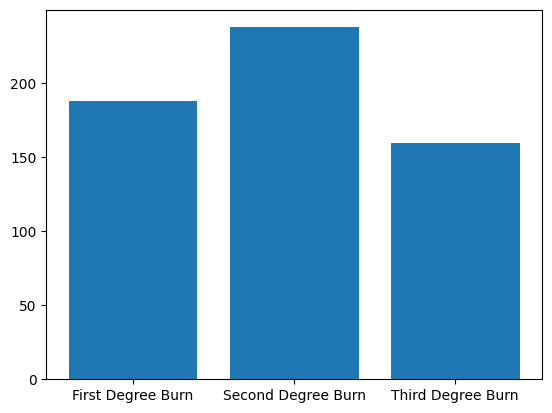

In [20]:
class_0_size = sum([1 for label in final_labels if label==0])
class_1_size = sum([1 for label in final_labels if label==1])
class_2_size = sum([1 for label in final_labels if label==2])

print('Number of samples in class 1: ', class_0_size)
print('Number of samples in class 2: ', class_1_size)
print('Number of samples in class 3: ', class_2_size)


numbers = [class_0_size, class_1_size, class_2_size]
labels = ['First Degree Burn', 'Second Degree Burn', 'Third Degree Burn']

plt.bar(labels, numbers)
plt.show()

Number of samples in class 1:  188
Number of samples in class 2:  238
Number of samples in class 3:  160


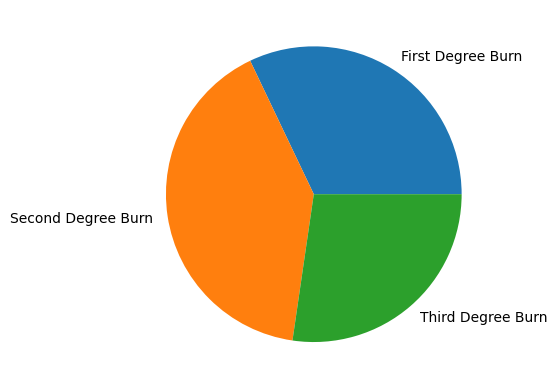

In [21]:
class_0_size = sum([1 for label in final_labels if label==0])
class_1_size = sum([1 for label in final_labels if label==1])
class_2_size = sum([1 for label in final_labels if label==2])

print('Number of samples in class 1: ', class_0_size)
print('Number of samples in class 2: ', class_1_size)
print('Number of samples in class 3: ', class_2_size)


numbers = [class_0_size, class_1_size, class_2_size]
labels = ['First Degree Burn', 'Second Degree Burn', 'Third Degree Burn']

plt.pie(numbers, labels=labels)
plt.show()

# **Transfer Learning**

## Paper's Architecture

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes=3):

        super(MyCNNModel, self).__init__()
        # Transfer Learning Layer (ResNet50)
        model = models.resnet50(pretrained=True)
        n_inputs = model.fc.in_features

        # Freeze the model's weights
        for param in model.parameters():
            param.requires_grad = False

        # Remove the avgpool and fc layers
        model = nn.Sequential(*list(model.children())[:-2])

        # Add a new layer to the ResNet50 model for the multi-label classification task.
        model.fc = nn.Sequential(nn.Conv2d(n_inputs, 128, kernel_size=3, padding=1, stride=1),
                                 nn.Softmax(dim=1),
                                 nn.MaxPool2d(kernel_size=4, stride=4, padding=1, dilation=1, ceil_mode=False),

                                 nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=2),
                                 nn.Softmax(dim=1),
                                 nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False),

                                 nn.Dropout(p=0.2),

                                 nn.Flatten(),
                                 nn.Linear(in_features = 64, out_features =3),
                                )

        # Unfreeze the last few layers of the model
        for param in model.fc.parameters():
            param.requires_grad = True

        self.resnet50 = model

    def forward(self, x):
        x = self.resnet50(x)
        #print('Shape Before Flattening: ', x.shape)
        # Flatten the output
        # x = x.view(x.size(0), -1)
        # print('Shape After Flattening: ', x.shape)
        return x

# Pretrained Models

### **1.ResNet50**

In [22]:
# Load the pre-trained Resnet50 model
resnet50_pretrained = models.resnet50(pretrained=True)

# Number of input features for the fc layer
n_inputs = resnet50_pretrained.fc.in_features

# Replace the fc layer with a new one for 3 classes
resnet50_pretrained.fc = nn.Linear(n_inputs, 3)

#print(resnet50_pretrained)

# Freeze The original resnet50 model
for name, param in resnet50_pretrained.named_parameters():
    param.requires_grad = False
    # print(name, param.requires_grad)


# Unfreeze The original resnet50 model fc layer
for param in resnet50_pretrained.fc.parameters():
    param.requires_grad = True
    # print(name, param.requires_grad)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.0MB/s]


### **2.DenseNet**

In [ ]:
# Load the pre-trained DenseNet121 model
densenet121_pretrained = models.densenet121(pretrained=True)

# Number of input features for the classifier layer
num_features = densenet121_pretrained.classifier.in_features

# Replace the classifier layer with a new one for 3 classes
densenet121_pretrained.classifier = nn.Linear(num_features, 3)

### **3.MobileNet**

In [ ]:
# Load the pre-trained MobileNetV2 model
mobilenet_v2_pretrained = models.mobilenet_v2(pretrained=True)

# For MobileNetV2, the input features to the classifier are 1280, so we use that number here.
mobilenet_v2_pretrained.classifier[1] = nn.Linear(mobilenet_v2_pretrained.last_channel, 3)

# Convolutional Layers & Dense Layers

### **1. ResNet50**

In [ ]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        # Load the pretrained ResNet50 model
        self.base_model = models.resnet50(pretrained=True)
        self.n_inputs = self.base_model.fc.in_features

        # Freeze the weights of the original layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze the last 4 layers' weights of the original model
        for name, param in self.base_model.named_parameters():
          if 'layer' in name:
            param.requires_grad = True

        # Remove the final classification layer
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        # Additional convolutional layers
        self.additional_layers = nn.Sequential(
            nn.Conv2d(self.n_inputs, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Dropout(p=0.2),
        )

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Dense layers
        self.dense_layers = nn.Sequential(nn.Flatten(),
                                          nn.Linear(64, 128),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.3),

                                          nn.Linear(128, 64),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.3)
                                          )

        # Output layer
        self.output_layer = nn.Sequential(
                                          #nn.Flatten(),
                                          nn.Linear(64, num_classes),
                                          )


    def forward(self, x):
        x = self.base_model(x)
        x = self.additional_layers(x)
        x = self.global_avg_pooling(x)
        x = self.dense_layers(x)
        x = self.output_layer(x)
        return x

## lr = 0.09200775000637837 , batch_size = 16 , epochs = 31
# # Accuracy of -- For convolutional layers only using 5 epochs compared to --
# model = ModifiedResNet50(num_classes=3)
# # Verify which layers are trainable
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

### **2. DenseNet**

In [ ]:
class ModifiedDenseNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedDenseNet, self).__init__()
        # Load the pretrained DenseNet model
        self.base_model = models.densenet121(pretrained=True)
        self.n_inputs = self.base_model.classifier.in_features

        # Remove the final classification layer
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        # Additional convolutional layers
        self.additional_layers = nn.Sequential(
            nn.Conv2d(self.n_inputs, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Dropout(p=0.2),
        )

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Dense layers
        self.dense_layers = nn.Sequential(nn.Flatten(),         # Flatten the tensor before passing to dense layers
                                          nn.Linear(64, 256),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(256, 128),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(128, 64),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.3)
                                        )

        # Output layer
        self.output_layer = nn.Sequential(
                                          nn.Linear(64, num_classes),
                                          )

        # Freeze the weights of the original layers
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)
        x = self.additional_layers(x)
        x = self.global_avg_pooling(x)
        #x = x.view(x.size(0), -1)         # Flatten the tensor before passing to dense layers
        x = self.dense_layers(x)
        x = self.output_layer(x)
        return x


# model = ModifiedDenseNet(num_classes= 3)
# # Verify which layers are trainable
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

### **3. MobileNet**

In [ ]:
class ModifiedMobileNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedMobileNet, self).__init__()
        # Load the pretrained MobileNet model
        self.base_model = models.mobilenet_v2(pretrained=True)
        self.n_inputs = self.base_model.classifier[1].in_features

        # Remove the final classification layer
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])

        # Additional convolutional layers
        self.additional_layers = nn.Sequential(
            nn.Conv2d(self.n_inputs, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # Adjust padding to avoid size mismatch
            nn.Dropout(p=0.2),
        )

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Dense Layers
        self.dense_layers = nn.Sequential(nn.Flatten(),           # Flatten the tensor before passing to dense layers
                                          nn.Linear(64, 128),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(128, 64),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.3)
                                          )

        # Output layer
        self.output_layer = nn.Sequential(
                                          nn.Linear(64, num_classes),
                                          )

        # Freeze the weights of the original layers
        for param in self.base_model.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.base_model(x)
        x = self.additional_layers(x)
        x = self.global_avg_pooling(x)
        #x = x.view(x.size(0), -1)           # Flatten the tensor before passing to dense layers
        x = self.dense_layers(x)
        x = self.output_layer(x)
        return x


# Accuracy of 44.07% For convolutional layers only using 5 epochs compared to 28%
#model = ModifiedMobileNet(num_classes=3)
# # Verify which layers are trainable
# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

# Dense Layers

### **1. ResNet50**


In [ ]:
resnet50_dense = models.resnet50(pretrained=True)
n_inputs = resnet50_dense.fc.in_features
#print(f'Before: {resnet50}')

# Unfreeze The original resnet50 model
for name, param in resnet50_dense.named_parameters():
    param.requires_grad = False

# Remove the fc layers
resnet50_dense = nn.Sequential(*list(resnet50_dense.children())[:-1])

# # Freeze the weights of the ResNet50 model
for param in resnet50_dense.parameters():
    param.requires_grad = False


# Add a new layer to the ResNet50 model for the multi-label classification task.
resnet50_dense.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(n_inputs*7*7, 128),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5),

                            nn.Linear(128, 64),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5),

                            nn.Linear(64, 3)
                            )



# Unfreeze the last few layers of the model
for param in resnet50_dense.fc.parameters():
    param.requires_grad = True
#print(f'After: {resnet50}')

### **2. DenseNet**

In [ ]:
densenet_dense = models.densenet121(pretrained=True)

# Replace the classifier with a new sequential classifier
densenet_dense.classifier = nn.Sequential(
    nn.Linear(1024, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(64, 3)  # Assuming you are classifying into 3 classes
)

# Freeze the features parameters
for param in densenet_dense.features.parameters():
    param.requires_grad = False

# Unfreeze the classifier parameters
for param in densenet_dense.classifier.parameters():
    param.requires_grad = True

### **3. Mobilenet**

In [ ]:
mobilenet_dense = models.mobilenet_v2(pretrained=True)
num_features = mobilenet_dense.classifier[1].in_features

mobilenet_dense.classifier[1] = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),

    nn.Linear(128, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),

    nn.Linear(64, 3)
)

for param in mobilenet_dense.parameters():
    param.requires_grad = False

for param in mobilenet_dense.classifier[1].parameters():
    param.requires_grad = True

MobileNet with dropout layer

In [ ]:
# Load the pre-trained MobileNetV2 model
mobilenet_v2_pretrained_dropout = models.mobilenet_v2(pretrained=True)

# Number of input features for the classifier layer
num_features = mobilenet_v2_pretrained_dropout.classifier[1].in_features

# Replace the classifier layer with a new one for 3 classes
mobilenet_v2_pretrained_dropout.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 3)
)

# Unfreezing

### **1. Unfreezing last 4 layers of ResNet50** (without any extra layers)

In [ ]:
# Load the pre-trained Resnet50 model
resnet50_model_unfreezed4 = models.resnet50(pretrained=True)

#Freeze all weights of the original model
for param in resnet50_model_unfreezed4.parameters():
  param.requires_grad = False

# Unfreeze the last 4 layers' weights of the original model
for name, param in resnet50_model_unfreezed4.named_parameters():
  #print(name)
  if 'layer' in name:
    param.requires_grad = True

# Check for parameters' condition
for name, param in resnet50_model_unfreezed4.named_parameters():
    print(name, param.requires_grad)

### **2. Unfreezing last 5 layers of DenseNet** (without any extra layers)

In [ ]:
# Load the pre-trained DenseNet121 model
densenet121_model_unfreezed5 = models.densenet121(pretrained=True)
# Number of input features for the classifier layer
num_features = densenet121_model_unfreezed5.classifier.in_features

# Replace the classifier layer with a new one for 3 classes
densenet121_model_unfreezed5.classifier = nn.Linear(num_features, 3)

# First, freeze all parameters by setting requires_grad to False
for param in densenet121_model_unfreezed5.parameters():
    param.requires_grad = False

# Unfreeze the classifier
for param in densenet121_model_unfreezed5.classifier.parameters():
    param.requires_grad = True

# Unfreeze layers in the last Dense Block (DenseBlock4 in DenseNet121)
# Note: This is an approximation since DenseNet layers are grouped into blocks ???
dense_block4 = densenet121_model_unfreezed5.features.denseblock4
for module in list(dense_block4.children())[-5:]:
    for param in module.parameters():
        param.requires_grad = True

# check which parameters are unfrozen
# for name, param in densenet121_model_unfreezed5.named_parameters():
#     if param.requires_grad:
#         print(name)

### **3. Unfreezing last 5 layers of MobileNet** (without any extra layers)

In [ ]:
mobilenet_model_unfreezed5 = models.mobilenet_v2(pretrained=True)

# For MobileNetV2, the input features to the classifier are 1280, so we use that number here.
mobilenet_model_unfreezed5.classifier[1] = nn.Linear(mobilenet_model_unfreezed5.last_channel, 3)

# Unfreeze the last 5 layers
# First, freeze all parameters for training
for param in mobilenet_model_unfreezed5.parameters():
    param.requires_grad = False

# Count the number of layers
total_layers = len(list(mobilenet_model_unfreezed5.features.children()))

# Unfreeze the last 5 layers
for layer in list(mobilenet_model_unfreezed5.features.children())[total_layers-5:]:
    for param in layer.parameters():
        param.requires_grad = True

# Helper Functions

In [23]:
# Define a custom dataset class that loads the images and labels in list form
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, root_path, imgs_names, labels, transform):
        self.imgs_names = imgs_names
        self.root_path = root_path
        self.labels = labels
        self.transform = transform

    # Get the size of the dataset
    def __len__(self):
        return len(self.labels)

    # Will return only single batch of the dataset as a tuple
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_path, self.imgs_names[idx]))
        image = self.transform(image).to(device)
        label = torch.tensor(int(self.labels[idx]))
        return image, label

### Seeding Functions

In [24]:
def set_seed(seed, disable_cudnn=False):
    np.random.seed(seed)

    torch.manual_seed(seed)           # Set the seed for generating random numbers for the current GPU
    torch.cuda.manual_seed_all(seed)  # Set the seed for generating random numbers for all GPUs

    rs = RandomState(MT19937(SeedSequence(seed))) # If any of the libraries or code rely on NumPy seed the global NumPy RNG

    if not disable_cudnn:
      torch.backends.cudnn.benchmark = False    # Causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance (the algorithm itself may be nondeterministic).
      torch.backends.cudnn.deterministic = True # Causes cuDNN to use a deterministic convolution algorithm, but may slow down performance.
                                                #  It will not guarantee that your training process is deterministic, if you are using other libraries that may use nondeterministic algorithms
    else:
      torch.backends.cudnn.enabled = False # Controls whether cuDNN is enabled or not. If you want to enable cuDNN, set it to True


# Set a fixed seed for reproducibility
seed = 42  # 12345
set_seed(seed)

In [25]:
def seed_batches(train_dataset,random_seed):

    num_train = len(train_dataset)
    indices = list(range(num_train))

    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_idx = indices
    train_sampler = SubsetRandomSampler(train_idx)

    return train_sampler

### Function to choose loss criterion & optimizer

In [26]:
def get_parameters(lr, model):
  # Cross Entropy Loss
  criterion = nn.CrossEntropyLoss()
  # Stochastic Gradient Descent optimizer
  optimizer = optim.SGD(model.parameters(), lr=lr)
  # Create the learning rate scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)  # Ignore the first 5 epochs and start decaying at the 6th epoch by a factor of 0.1 at the first stop in decreasing
  model = model.to(device)
  return model, optimizer, criterion, scheduler

### Function to train the model

In [27]:
def train_model(model, criterion, optimizer, train_loader, scheduler, test_loader, epochs=30):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        print(f'Training Epoch [{epoch}/{epochs-1}]')
        for images, labels in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # print(f'Output {epoch}', outputs)
            # print(f'Output shape: {outputs.shape}')

            # Calculate the loss & Backpropagate
            loss = criterion(outputs, labels)
            loss.backward()

            # Update the weights
            optimizer.step()

            scheduler.step(loss)        # Update the learning rate using the train loss
            running_train_loss += loss.item() * images.size(0) #scales the loss value to represent the total cumulative loss for all the samples in the batch.


        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)


        model.eval()
        running_test_loss = 0.0
        # Test Losses
        with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              running_test_loss += loss.item() * images.size(0)

        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        print(f'Epoch [{epoch}/{epochs-1}], '
              f'Training Loss: {epoch_train_loss:.4f}, '
              f'Test Loss: {epoch_test_loss:.4f}')

    torch.save(model, '/content/drive/My Drive/best_model.pkl')

    return model, train_losses, test_losses

### Function to evaluate the model


In [28]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


def evaluate_model(model, criterion, train_loader, test_loader, class_names):
    # Evaluate on training set
    model.eval()  # Set the model to evaluation mode
    total_correct_train = 0
    total_samples_train = 0
    y_true_train = []
    y_pred_train = []

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples_train += labels.size(0)
            total_correct_train += (predicted == labels).sum().item()

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

    train_accuracy = total_correct_train / total_samples_train
    print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

    # Evaluate on test set
    total_correct_test = 0
    total_samples_test = 0
    y_true_test = []
    y_pred_test = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples_test += labels.size(0)
            total_correct_test += (predicted == labels).sum().item()

            y_true_test.extend(labels.cpu().numpy())
            y_pred_test.extend(predicted.cpu().numpy())

    test_accuracy = total_correct_test / total_samples_test
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    f1 = f1_score(y_true_test, y_pred_test, average='weighted')
    precision = precision_score(y_true_test, y_pred_test, average='weighted')
    recall = recall_score(y_true_test, y_pred_test, average='weighted')

    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    # Plot confusion matrix for test set
    plot_confusion_matrix(y_true_test, y_pred_test, class_names)

    torch.save(model, f'/content/drive/My Drive/model_{test_accuracy * 100:.2f}%.pkl')

    return train_accuracy, test_accuracy



### Function to Hypertune the model


In [ ]:
# A Function For choosing the best lr, batch size & no. of epochs
def parameters_tuning(trial,model):
    # Hyperparameters to be optimized
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) #1e-5, 1e-3
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128]) # , 256, 512
    epochs = trial.suggest_int('epochs', 10, 30) # 30, 60

    # Transformations for the training and test images.
    Default_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    ])

    # Create Train & Test Datasets
    train_dataset = MultiLabelDataset('/content/train/images', train_image_names, train_labels, Default_transform)
    test_dataset = MultiLabelDataset('/content/test/images', test_image_names, test_labels, Default_transform)
    # Create Train & Test Loaders
    train_sampler = seed_batches(train_dataset, 42)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # Create and train the model
    model, optimizer, criterion, scheduler = get_parameters(lr, mobilenet_model_unfreezed5)
    model, train_losses, test_losses = train_model(model, criterion, optimizer, train_loader, scheduler, test_loader, epochs)

    # Model's Evaluation
    # test_accuracy = evaluate_model(model, criterion, train_loader, test_loader, class_names=["First degree", "Second degree", "Third degree"])
    test_accuracy = evaluate_model(model, criterion, train_loader, test_loader, class_names=["First degree & Second degree", "Third degree"])

    return test_accuracy

### Function to train without using augmentation

In [ ]:
# Function to calculate the train & test losses without using augmentation
def Train_without_augmentation(model, lr, batch_size, epochs):

  # Transformations for the training and test images.
  Default_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

  ])


  train_dataset = MultiLabelDataset('/content/train/images', train_image_names, train_labels, Default_transform)
  test_dataset = MultiLabelDataset('/content/test/images', test_image_names, test_labels, Default_transform)


  # Create Train & Test Loaders
  train_sampler = seed_batches(train_dataset, 42)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler) #128
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) #128

  model, optimizer, criterion, scheduler = get_parameters(lr, model) #0.001
  model, train_losses, test_losses = train_model(model, criterion, optimizer, train_loader, scheduler, test_loader, epochs=epochs)  #30


  # Evaluate the model
  # evaluate_model(model, criterion, train_loader, test_loader, class_names=["First degree", "Second degree", "Third degree"])
  evaluate_model(model, criterion, train_loader, test_loader, class_names=["First degree & Second degree", "Third degree"])

  # Plotting the losses
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
  plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Test Loss')
  plt.legend()
  plt.show()

### Function to train using augmentation

In [ ]:
def Train_using_augmentation(model, lr, batch_size, epochs):

    # Transform the training and test images (Normalization, resizing, conversion to tensor)
    original_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    ])


    # Define your augmentation transforms

    horizontal_flipping_transform = transforms.Compose([
                                              transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                              transforms.RandomHorizontalFlip(),     # Randomly flip the input horizontally
                                              ])



    vertical_flipping_transform = transforms.Compose([
                                              transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                              transforms.RandomVerticalFlip(),       # Randomly flip the input vertically
                                              ])

    rotational_transform = transforms.Compose([
                                              transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                              transforms.RandomRotation(degrees=45),
                                              ])

    shifting_transform = transforms.Compose([
                                              transforms.Resize((224, 224)),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                              transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation with translation
                                              ])


    original_dataset = MultiLabelDataset('/content/train/images', train_image_names, train_labels, original_transform)
    augmented_dataset_horizontal = MultiLabelDataset('/content/train/images', train_image_names, train_labels, horizontal_flipping_transform)
    augmented_dataset_vertical = MultiLabelDataset('/content/train/images', train_image_names, train_labels, vertical_flipping_transform)
    augmented_dataset_rotational = MultiLabelDataset('/content/train/images', train_image_names, train_labels, rotational_transform)
    augmented_dataset_shifted = MultiLabelDataset('/content/train/images', train_image_names, train_labels, shifting_transform)
    test_dataset = MultiLabelDataset('/content/test/images', test_image_names, test_labels, shifting_transform)


    combined_dataset = ConcatDataset([original_dataset, augmented_dataset_horizontal, augmented_dataset_vertical, augmented_dataset_rotational, augmented_dataset_shifted])
    # Create Train & Test Loaders
    train_sampler = seed_batches(combined_dataset, 42)
    combined_train_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    original_dataset_size = len(original_dataset)
    print(f"Original Dataset Size: {original_dataset_size} samples")
    augmented_dataset_size = len(augmented_dataset_horizontal) + len(augmented_dataset_vertical) + len(augmented_dataset_rotational) + len(augmented_dataset_shifted)
    print(f"Augmnented Dataset Size: {augmented_dataset_size} samples")
    combined_dataset_size = len(combined_dataset)
    print(f"Combined Dataset Size: {combined_dataset_size} samples")

    # Train your model
    model, optimizer, criterion, scheduler = get_parameters(lr, model)
    model, train_losses, test_losses = train_model(model, criterion, optimizer, combined_train_loader, scheduler, test_loader, epochs=epochs)
    # test_accuracy = evaluate_model(model, criterion, combined_train_loader, test_loader, class_names=["First degree", "Second degree", "Third degree"])
    test_accuracy = evaluate_model(model, criterion, combined_train_loader, test_loader, class_names=["First degree & Second degree", "Third degree"])

    # Plotting the losses
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Balancing Data in Binary Classification Approach

In [42]:
def Train_using_balancing_augmentation(model, lr, batch_size, epochs):

    # Transform the training and test images (Normalization, resizing, conversion to tensor)
    original_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    # Define your augmentation transforms
    augmentation_transforms = [
        transforms.RandomHorizontalFlip(),  # Randomly flip the input horizontally
        transforms.RandomVerticalFlip(),    # Randomly flip the input vertically
        transforms.RandomRotation(degrees=45),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation with translation
    ]

    # Step 1: Calculate the number of samples needed to balance the classes
    class_counts = {0: 0, 1: 0}
    for label in train_labels:
        class_counts[label] += 1

    majority_class_size = max(class_counts.values())
    print ("majority_class_size " , majority_class_size)
    minority_class_size = min(class_counts.values())
    print ("minority_class_size " , minority_class_size)
    samples_needed = majority_class_size - minority_class_size

    # Step 2: Create a balanced dataset
    original_dataset = MultiLabelDataset('/content/train/images', train_image_names, train_labels, original_transform)
    test_dataset = MultiLabelDataset('/content/test/images', test_image_names, test_labels, original_transform)

    minority_class_indices = [i for i, label in enumerate(train_labels) if label == 1]

    # Randomly choose samples from the minority class to augment until we reach the desired size
    augmented_samples = []
    while len(augmented_samples) < samples_needed:
        sample_idx = random.choice(minority_class_indices)
        sample_image_name = train_image_names[sample_idx]
        sample_label = train_labels[sample_idx]

        # Apply a random augmentation to the selected sample
        augmentation_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            random.choice(augmentation_transforms),
        ])
        augmented_sample = MultiLabelDataset('/content/train/images', [sample_image_name], [sample_label], augmentation_transform)
        augmented_samples.append(augmented_sample)

    # Combine the original dataset with the augmented samples
    balanced_dataset = ConcatDataset([original_dataset] + augmented_samples)

    # Create Train & Test Loaders
    train_sampler = seed_batches(balanced_dataset, 42)
    combined_train_loader = torch.utils.data.DataLoader(balanced_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    original_dataset_size = len(original_dataset)
    print(f"Original Dataset Size: {original_dataset_size} samples")
    augmented_dataset_size = len(augmented_samples)
    print(f"Augmnented Dataset Size: {augmented_dataset_size} samples")
    combined_dataset_size = len(balanced_dataset)
    print(f"Combined Dataset Size: {combined_dataset_size} samples")

    # Train your model
    model, optimizer, criterion, scheduler = get_parameters(lr, model)
    model, train_losses, test_losses = train_model(model, criterion, optimizer, combined_train_loader, scheduler, test_loader, epochs=epochs)
    # test_accuracy = evaluate_model(model, criterion, combined_train_loader, test_loader, class_names=["First degree", "Second degree", "Third degree"])
    test_accuracy = evaluate_model(model, criterion, combined_train_loader, test_loader, class_names=["First degree & Second degree", "Third degree"])

    # Plotting the losses
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(test_losses)+1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### A Function For choosing the best lr, batch size & no. of epochs

In [ ]:
def parameters_tuning_augmented_data(trial,model):
    # Hyperparameters to be optimized
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) #1e-5, 1e-3
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128]) # , 256, 512
    epochs = trial.suggest_int('epochs', 10, 30) # 30, 60

    # Get Augmented Train & Test Loaders
    train_loader, test_loader = get_augmented_data(model, lr, batch_size, epochs)

    # Create and train the model
    model, optimizer, criterion, scheduler = get_parameters(lr, model)
    model, train_losses, test_losses = train_model(model, criterion, optimizer, train_loader, scheduler, test_loader, epochs)

    # Model's Evaluation
    test_acc = evaluate_model(model, criterion, train_loader, test_loader, class_names=["First degree", "Second degree", "Third degree"])

    return test_acc

In [ ]:
# # Study on Augmented Data (4 Augmentations)
# study = optuna.create_study(direction='maximize')
# study.optimize(parameters_tuning_augmented_data, n_trials=50)

# if len(study.trials) > 0:
#   print('Number of finished trials: ', len(study.trials))
#   print('Best trial:')
#   trial = study.best_trial
#   print('Value: ', trial.value)
#   print('Params: ')
#   for key, value in trial.params.items():
#       print(f'{key}: {value}')
# else:
#     print('No trials have been completed yet.')

# Training

### ResNet50 Combinations

In [ ]:
Train_without_augmentation(resnet50_pretrained, lr=0.001, batch_size=128, epochs=30)

majority_class_size  336
minority_class_size  132
Original Dataset Size: 468 samples
Augmnented Dataset Size: 204 samples
Combined Dataset Size: 672 samples
Training Epoch [0/30]
Epoch [0/30], Training Loss: 2.1728, Test Loss: 1.3035
Training Epoch [1/30]
Epoch [1/30], Training Loss: 1.0466, Test Loss: 1.3086
Training Epoch [2/30]
Epoch [2/30], Training Loss: 1.0132, Test Loss: 1.3116
Training Epoch [3/30]
Epoch [3/30], Training Loss: 1.0206, Test Loss: 1.3101
Training Epoch [4/30]
Epoch [4/30], Training Loss: 1.0007, Test Loss: 1.4042
Training Epoch [5/30]
Epoch [5/30], Training Loss: 0.9964, Test Loss: 1.3160
Training Epoch [6/30]
Epoch [6/30], Training Loss: 1.0007, Test Loss: 1.2546
Training Epoch [7/30]
Epoch [7/30], Training Loss: 1.0275, Test Loss: 1.3110
Training Epoch [8/30]
Epoch [8/30], Training Loss: 1.0559, Test Loss: 1.3352
Training Epoch [9/30]
Epoch [9/30], Training Loss: 1.0306, Test Loss: 1.3334
Training Epoch [10/30]
Epoch [10/30], Training Loss: 1.0310, Test Loss: 1

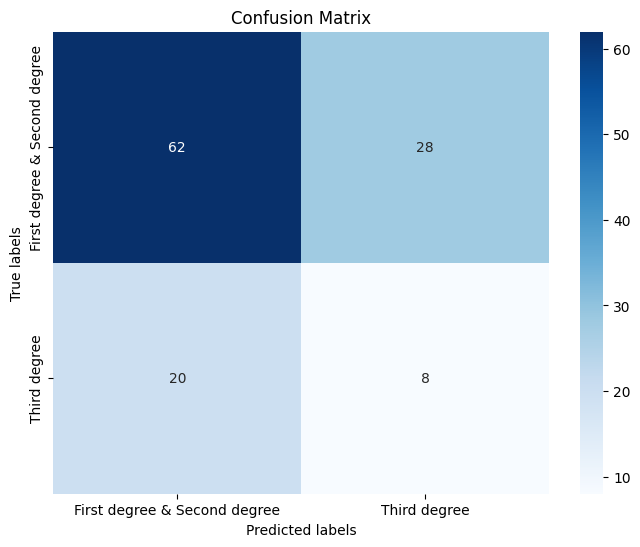

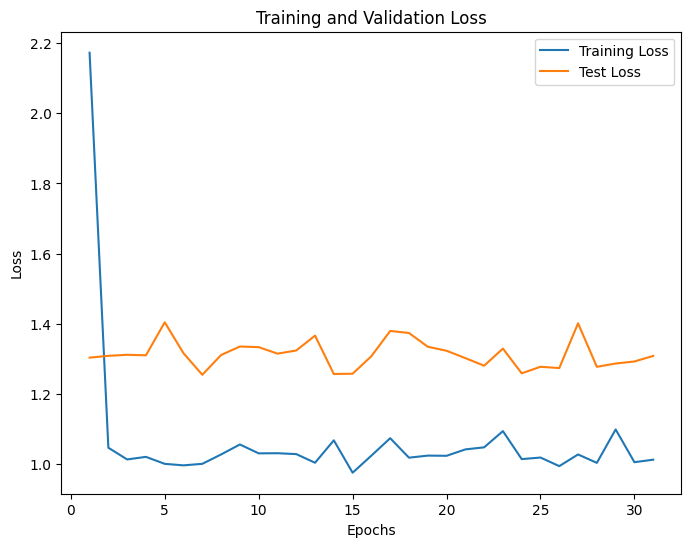

In [44]:
Train_using_balancing_augmentation(resnet50_pretrained,lr=0.09200775000637837, batch_size=16, epochs=31)

In [ ]:
Train_without_augmentation(resnet50_model_unfreezed4, lr=0.09200775000637837, batch_size=16, epochs=31)

In [ ]:
Train_without_augmentation(resnet50_dense, lr=0.09200775000637837, batch_size=16, epochs=31)

In [ ]:
Train_without_augmentation(ModifiedResNet50(num_classes=3), lr=0.001, batch_size=128, epochs=30)

In [ ]:
Train_using_augmentation(resnet50_pretrained, lr=0.001, batch_size=128, epochs=30)

In [ ]:
Train_using_augmentation(resnet50_pretrained, lr=0.09200775000637837, batch_size=16, epochs=31)

In [ ]:
Train_using_augmentation(resnet50_model_unfreezed4, lr=0.09200775000637837, batch_size=16, epochs=31)

In [ ]:
Train_using_augmentation(resnet50_dense, lr=0.09200775000637837, batch_size=16, epochs=31)

In [ ]:
Train_using_augmentation(ModifiedResNet50(num_classes=3), lr=0.001, batch_size=128, epochs=30)

### MobileNet Combinations

In [ ]:
Train_without_augmentation(mobilenet_v2_pretrained, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_without_augmentation(mobilenet_model_unfreezed5, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_without_augmentation(mobilenet_v2_pretrained_dropout, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_without_augmentation(mobilenet_dense, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_without_augmentation(ModifiedMobileNet(num_classes=3), lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_using_augmentation(mobilenet_v2_pretrained, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_using_augmentation(mobilenet_model_unfreezed5, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_using_augmentation(mobilenet_v2_pretrained_dropout, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_using_augmentation(mobilenet_dense, lr=1.9181231072698998e-05, batch_size=32, epochs=24)

In [ ]:
Train_using_augmentation(ModifiedMobileNet(num_classes=3), lr=1.9181231072698998e-05, batch_size=32, epochs=24)

### DenseNet Combinations

In [ ]:
Train_without_augmentation(densenet121_pretrained, lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_without_augmentation(densenet121_model_unfreezed5, lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_without_augmentation(densenet_dense, lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_without_augmentation(ModifiedDenseNet(num_classes= 3), lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_using_augmentation(densenet121_pretrained, lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_using_augmentation(densenet121_model_unfreezed5, lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_using_augmentation(densenet_dense, lr=0.001, batch_size=16, epochs=30)

In [ ]:
Train_using_augmentation(ModifiedDenseNet(num_classes= 3), lr=0.001, batch_size=16, epochs=30)